# 4. CLASIFICACION DE SELLERS

### Se propondrán 2 formas de clasificar a los sellers, se compararán los resultados y se optará por una solución

In [1]:
# Importamos las librerias
import pandas as pd

In [2]:
# defino el día de la consulta para importar el csv
from datetime import datetime
day = datetime.today().strftime('%Y-%m-%d').replace('-','')
day
#Defino el dia que se creo el dataset
day = '20220318'

In [3]:
# Importamos los datos
data_original = pd.read_csv(f'../data/{day}_dataset_sellers.csv',index_col=None)

#### Metricas Seleccionadas
- cancellations_rate
- claims_rate
- delayed_handling_time_rate
- avg_ticket
- antiquity_ages


In [4]:
data_original.columns

Index(['Unnamed: 0', 'categoria_MLA', 'seller', 'fecha_registro',
       'power_seller_status', 'level_id', 'cancellations_value',
       'cancellations_rate', 'claims_value', 'claims_rate',
       'delayed_handling_time_value', 'delayed_handling_time_rate',
       'sales_value', 'transactions_total_historic',
       'transactions_canceled_historic', 'transactions_completed_historic',
       'rating_negative', 'rating_neutral', 'rating_positive', 'state', 'city',
       'total_sales_amount', 'total_items_sold', 'total_profits_amount',
       'avg_ticket', 'categoria_name', 'register_date', 'antiquity_ages',
       'transactions_canceled_historic_rate'],
      dtype='object')

In [5]:
# Filtro las metricas que se utilizarán en el análisis
data = data_original[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket','antiquity_ages']]
data = data.fillna(0)

In [6]:
estadisticos = data.describe().apply(lambda y: y.apply(lambda x: format(x, 'f')))
estadisticos

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages
count,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000
mean,0.002370,0.005494,0.024621,10112.491208,7.406001
std,0.004146,0.005859,0.032194,23528.152190,5.334253
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002300,1574.030000,3.000000
50%,0.000000,0.004300,0.011600,3507.798046,6.000000
75%,0.003600,0.009500,0.034250,8305.540515,11.000000
max,0.036200,0.039500,0.210500,520000.000000,22.000000


### 3.a Clasificacion con algoritmo K-MEANS

In [7]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

In [8]:
data_kmeans = data[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket']]
data_kmeans = data.fillna(0)

In [9]:
X = np.array(data)

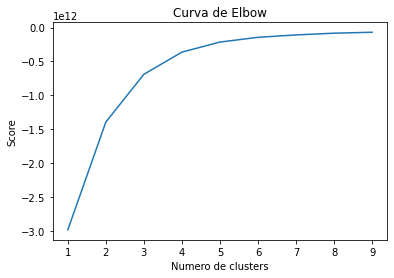

In [10]:
# estimo la curva de elbow para elegir la cantidad de k para el algoritmo, entre 1 y 10
n_clu = range(1, 10)
#calculo los clusters para cada valor de clusters
kmeans = [KMeans(n_clusters=i) for i in n_clu]
# calculo el score de los resultados
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
# Visualizo la curva para elegir el valor K del algoritmo
plt.plot(n_clu,score)
plt.title('Curva de Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.show()

##### La curva se aplanaen 4, se utilizará ese valor K, y para el equipo comercial puede ser una cantidad de grupos interesante para focalizar acciones

In [11]:
# calculamos el algoritmo k_means
kmeans = KMeans(n_clusters=4,random_state=0).fit(X)
centroids = kmeans.cluster_centers_
# printeamos los centroides de los clusters
print(centroids)
labels = kmeans.labels_
print(labels)

[[2.34073767e-03 5.40294240e-03 2.41652093e-02 4.63912732e+03
  7.38955657e+00]
 [3.10138889e-03 4.94444444e-03 2.51500000e-02 1.26129404e+05
  6.90277778e+00]
 [3.70000000e-03 4.96666667e-03 2.65166667e-02 4.22493833e+05
  7.83333333e+00]
 [2.53252525e-03 6.46282828e-03 2.89642424e-02 4.16012758e+04
  7.63434343e+00]]
[0 0 0 ... 0 0 0]


In [12]:
# paso los resultados al dataframe
data['kmeans'] = labels
# tambien los incluyo en el data original
data_original['kmeans'] = labels

In [13]:
# agrupo por cluster y veo su %
grupos_kmeans = data.groupby('kmeans', as_index=False).size()
grupos_kmeans['porcentaje'] = round(grupos_kmeans['size']/len(data)*100,1)
grupos_kmeans

,kmeans,size,porcentaje
0,0,4826,89.4
1,1,72,1.3
2,2,6,0.1
3,3,495,9.2


#### Miramos la distribucion de cada cluster

In [14]:
data.loc[data.kmeans == 0].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,kmeans
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.0
mean,0.002341,0.005403,0.024165,4639.127321,7.389557,0.0
std,0.004075,0.005750,0.031587,4685.507240,5.345002,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.002500,1445.596384,3.000000,0.0
50%,0.000000,0.004300,0.011300,2926.385714,6.000000,0.0
75%,0.003500,0.009200,0.033200,6160.621622,11.000000,0.0
max,0.036200,0.039200,0.210500,23000.000000,22.000000,0.0


In [15]:
data.loc[data.kmeans == 1].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,kmeans
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.0
mean,0.003101,0.004944,0.025150,126129.403783,6.902778,1.0
std,0.006508,0.005986,0.034267,41068.672278,5.412973,0.0
min,0.000000,0.000000,0.000000,83899.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,93250.112637,3.000000,1.0
50%,0.000000,0.000000,0.012350,113299.442003,6.000000,1.0
75%,0.002600,0.010125,0.034925,148674.000000,8.000000,1.0
max,0.035000,0.019500,0.123500,252933.615851,20.000000,1.0


In [16]:
data.loc[data.kmeans == 2].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,kmeans
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.0
mean,0.003700,0.004967,0.026517,422493.833333,7.833333,2.0
std,0.005844,0.007843,0.023796,61087.052525,8.084965,0.0
min,0.000000,0.000000,0.000000,333999.000000,0.000000,2.0
25%,0.000000,0.000000,0.004450,401249.000000,1.250000,2.0
50%,0.000000,0.000000,0.029950,419999.500000,6.500000,2.0
75%,0.006975,0.009375,0.044350,439474.500000,12.500000,2.0
max,0.012900,0.017300,0.054100,520000.000000,20.000000,2.0


In [17]:
data.loc[data.kmeans == 3].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,kmeans
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,0.002533,0.006463,0.028964,41601.275780,7.634343,3.0
std,0.004366,0.006730,0.037221,15520.666254,5.188124,0.0
min,0.000000,0.000000,0.000000,23145.000000,0.000000,3.0
25%,0.000000,0.000000,0.000700,28836.125000,4.000000,3.0
50%,0.000000,0.005600,0.013900,37682.750000,6.000000,3.0
75%,0.004300,0.011500,0.043000,50383.309524,11.000000,3.0
max,0.020900,0.039500,0.196400,83527.290000,22.000000,3.0


In [18]:
# analizamos los valores de la silueta
silhouette_vals = silhouette_samples(X, labels)
silhouette_vals

array([0.9081252 , 0.91537627, 0.91619026, ..., 0.90173948, 0.89448782,
       0.91558739])

Text(0.5, 1.02, 'Silhouette plot por cluster')

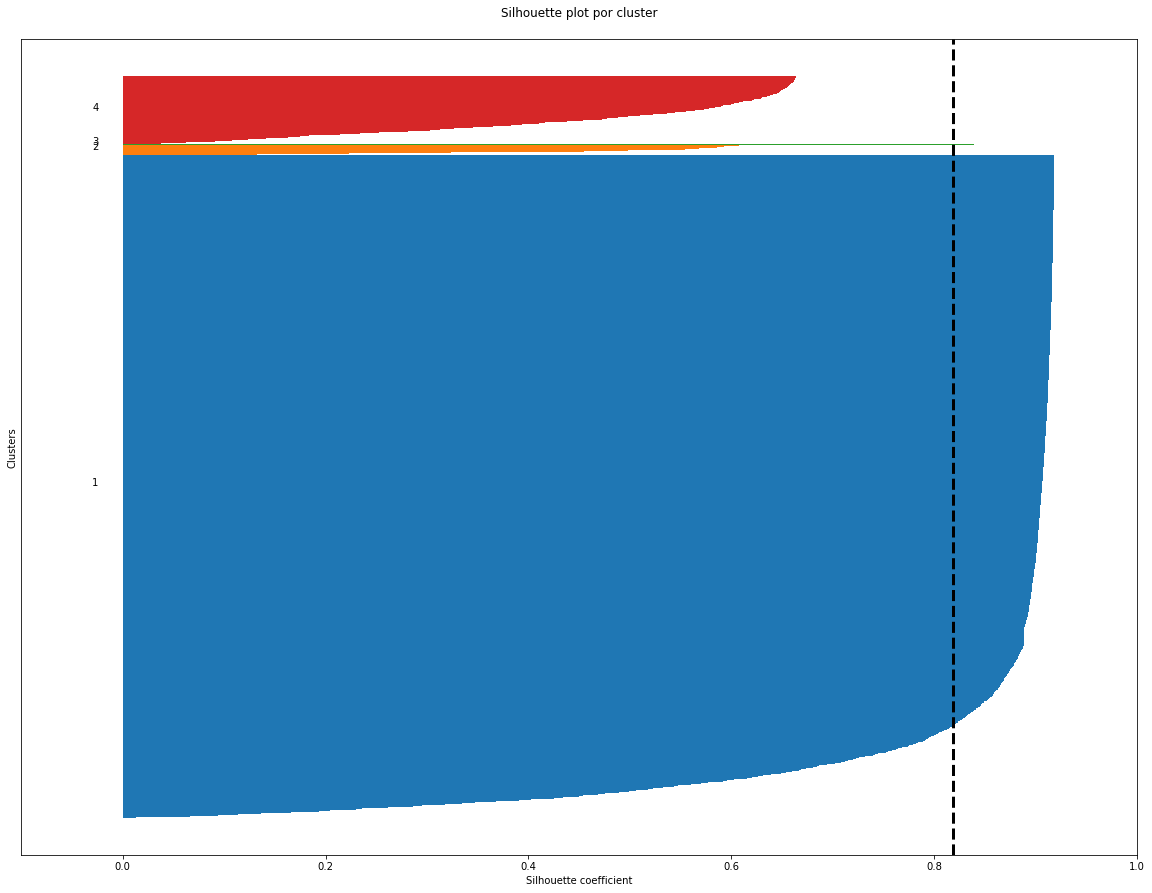

In [19]:
plt.rcParams['figure.figsize'] = (20,15)
ax = plt.axes()
# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=2)
    ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)

# calculamos el promedio del score de siluetas
avg_score = np.mean(silhouette_vals)
ax.axvline(avg_score, linestyle='--', linewidth=3, color='black')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.set_xlabel('Silhouette coefficient')
ax.set_ylabel('Clusters')
ax.set_title('Silhouette plot por cluster', y=1.02)

#### Luego de visualizar el grafico de siluetas y ver la similitud entre el cluster 2 y 4 se calcular nuevamente con menos clusters

In [20]:
data = data_original[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket','antiquity_ages']]
data = data.fillna(0)

In [21]:
# calculamos el algoritmo k_means pero con 2 clusters luego de ver el grafico de siluetas
kmeans_2 = KMeans(n_clusters=2,random_state=0).fit(X)
centroids_2 = kmeans_2.cluster_centers_
# printeamos los centroides de los clusters
print(centroids)
labels_2 = kmeans_2.labels_
print(labels_2)

[[2.34073767e-03 5.40294240e-03 2.41652093e-02 4.63912732e+03
  7.38955657e+00]
 [3.10138889e-03 4.94444444e-03 2.51500000e-02 1.26129404e+05
  6.90277778e+00]
 [3.70000000e-03 4.96666667e-03 2.65166667e-02 4.22493833e+05
  7.83333333e+00]
 [2.53252525e-03 6.46282828e-03 2.89642424e-02 4.16012758e+04
  7.63434343e+00]]
[0 0 0 ... 0 0 0]


In [22]:
# pasamos los datos al data
data['kmeans_2'] = labels_2
# tambien los incluimos en el dataframe original
data_original['kmeans_2'] = labels_2

In [23]:
data.value_counts('kmeans_2')

kmeans_2
0    5239
1     160
dtype: int64

In [24]:
silhouette_vals = silhouette_samples(X, labels_2)
silhouette_vals

array([0.94582193, 0.94561832, 0.94735859, ..., 0.9397755 , 0.93682952,
       0.94728285])

Text(0.5, 1.02, 'Silhouette plot por cluster')

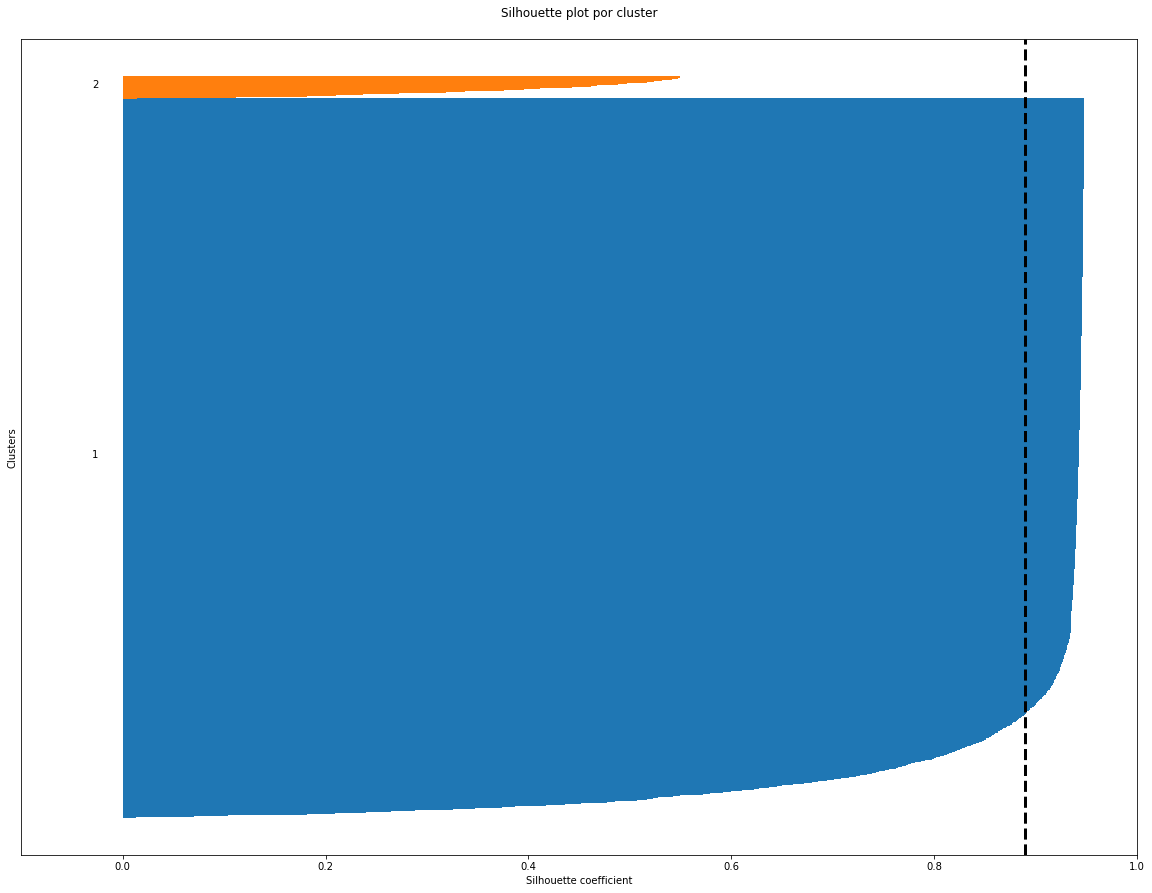

In [25]:
ax = plt.axes()
# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels_2)):
    cluster_silhouette_vals = silhouette_vals[labels_2 == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=2)
    ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)

plt.rcParams['figure.figsize'] = (20,15)
avg_score = np.mean(silhouette_vals)
ax.axvline(avg_score, linestyle='--', linewidth=3, color='black')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.set_xlabel('Silhouette coefficient')
ax.set_ylabel('Clusters')
ax.set_title('Silhouette plot por cluster', y=1.02)

In [26]:
# calculamos los 
grupos_kmeans_2 = data.groupby('kmeans_2', as_index=False).size()
grupos_kmeans_2['porcentaje'] = round(grupos_kmeans['size']/len(data)*100,1)
grupos_kmeans_2

,kmeans_2,size,porcentaje
0,0,5239,89.4
1,1,160,1.3


### 3. b. CLASIFICACIÓN SEGÚN REGLAS DE NEGOCIO

Se clasificaran los sellers en 4 grupos: 
1. **Relevancia Alta – Perfil Alto:** ticket promedio mayor a la mediana y 0 en 2 variables de perfil
2. **Relevancia Alta – Perfil Medio:** ticket promedio mayor a la mediana y cuentan con cancelaciones o reclamos o demoras
3. **Relevancia Media – Perfil Alto:** ticket promedio Menor a la mediana y 0 en 2 variables de perfil
4. **Relevancia Media – Perfil Medio:** ticket promedio Menor a la mediana y cuentan con cancelaciones o reclamos o demoras



#### Primero calculamos un scoring de las variables de perfil para tener valores de los sellers

In [27]:
# incluyo 0 o 1 dependiendo si su % de la variable es 0 o diferente de 0
data.loc[data.cancellations_rate == 0, "cancelations"] = 1
data.loc[data.cancellations_rate != 0, "cancelations"] = 0
data.loc[data.claims_rate == 0, "claims"] = 1
data.loc[data.claims_rate != 0, "claims"] = 0
data.loc[data.delayed_handling_time_rate == 0, "delays"] = 1
data.loc[data.delayed_handling_time_rate != 0, "delays"] = 0

In [28]:
data['scoring_perfil'] = data[['cancelations','claims','delays']].sum(axis=1)

In [29]:
# Defino perfil Relevancia Alta-Perfil Medio
data.loc[(data.scoring_perfil <= 1) & (data.avg_ticket >= float(estadisticos.avg_ticket['50%'])), 'perfil'] = "relevancia alta-perfil medio"
# Defino perfil Relevancia Alta-Perfil Alto
data.loc[(data.scoring_perfil >= 2) & (data.avg_ticket >= float(estadisticos.avg_ticket['50%'])), 'perfil'] = "relevancia alta-perfil alto"
# Defino perfil Relevancia Media-Perfil Alto
data.loc[(data.scoring_perfil <= 1) & (data.avg_ticket < float(estadisticos.avg_ticket['50%'])), 'perfil'] = "relevancia media-perfil medio"
# Defino perfil Relevancia Media-Perfil Medio
data.loc[(data.scoring_perfil >= 2) & (data.avg_ticket < float(estadisticos.avg_ticket['50%'])), 'perfil'] = "relevancia media-perfil alto"

In [30]:
grupos = data.groupby('perfil', as_index=False).size()
grupos['porcentaje'] = round(grupos['size']/len(data)*100,1)
grupos

,perfil,size,porcentaje
0,relevancia alta-perfil alto,995,18.4
1,relevancia alta-perfil medio,1704,31.6
2,relevancia media-perfil alto,1096,20.3
3,relevancia media-perfil medio,1604,29.7


In [31]:
#chequeamos que todos los sellers esten clasificados
data.perfil.isnull().sum()

0

In [32]:
# pasamos los datos al dataframe original
data_original['rules'] = data['perfil']

# 3.c. Clasificacion en base a algoritmo DBSCAN

In [33]:
from sklearn.cluster import DBSCAN

In [34]:
data = data_original[['cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket','antiquity_ages']]
data = data.fillna(0)

In [35]:
# estandarizamos los datos
X_db = StandardScaler().fit_transform(data)

In [36]:
# se deja por default el eps (0.5) y se incluyen que los clusters contengan minimo 200 casos
db = DBSCAN(min_samples=200).fit(X_db)

In [37]:
labels_2 = db.labels_
print(labels_2)

[-1 -1 -1 ...  0 -1  0]


In [38]:
# pasamos los datos al dataframe
data['dbscan']= db.labels_
# pasamos los datos al dataframe original
data_original['dbscan']= db.labels_

In [39]:
data.value_counts('dbscan')

dbscan
-1    3873
 0    1526
dtype: int64

In [40]:
data.loc[data.dbscan == 0].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,dbscan
count,1526.000000,1526.000000,1526.00000,1526.000000,1526.000000,1526.0
mean,0.000088,0.000697,0.00482,3693.611835,6.335518,0.0
std,0.000368,0.001347,0.00684,3970.497643,4.706202,0.0
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.00000,1177.787500,2.000000,0.0
50%,0.000000,0.000000,0.00140,2302.030000,5.000000,0.0
75%,0.000000,0.000300,0.00750,4846.267500,10.000000,0.0
max,0.002800,0.005400,0.03000,22600.000000,17.000000,0.0


In [41]:
data.loc[data.dbscan == -1].describe()

,cancellations_rate,claims_rate,delayed_handling_time_rate,avg_ticket,antiquity_ages,dbscan
count,3873.000000,3873.000000,3873.000000,3873.000000,3873.000000,3873.0
mean,0.003269,0.007384,0.032423,12641.592660,7.827782,-1.0
std,0.004588,0.005873,0.034801,27256.166414,5.505963,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,0.000000,0.002100,0.006300,1812.548599,3.000000,-1.0
50%,0.000900,0.007100,0.019500,4299.000000,6.000000,-1.0
75%,0.005300,0.011400,0.047100,11000.875239,12.000000,-1.0
max,0.036200,0.039500,0.210500,520000.000000,22.000000,-1.0


# 4. Extraemos los resultados para compartir con el equipo comercial

In [42]:
data_original.columns

Index(['Unnamed: 0', 'categoria_MLA', 'seller', 'fecha_registro',
       'power_seller_status', 'level_id', 'cancellations_value',
       'cancellations_rate', 'claims_value', 'claims_rate',
       'delayed_handling_time_value', 'delayed_handling_time_rate',
       'sales_value', 'transactions_total_historic',
       'transactions_canceled_historic', 'transactions_completed_historic',
       'rating_negative', 'rating_neutral', 'rating_positive', 'state', 'city',
       'total_sales_amount', 'total_items_sold', 'total_profits_amount',
       'avg_ticket', 'categoria_name', 'register_date', 'antiquity_ages',
       'transactions_canceled_historic_rate', 'kmeans', 'kmeans_2', 'rules',
       'dbscan'],
      dtype='object')

In [43]:
data_extract = data_original[['categoria_MLA', 'categoria_name', 'seller','state', 'city','rules','cancellations_rate','claims_rate','delayed_handling_time_rate','avg_ticket']]
data_extract.rename(columns={'rules': 'grupo'},inplace=True)
data_extract.to_csv(f'../data/{day}_sellers_clasificados.csv',index=False)

C:\Users\Ignacio\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
